# MobileNetV2 — 垃圾分类
<br>
<hr>

## 1. 实验简介

MindSpore是最佳匹配Ascend（昇腾）芯片的开源AI计算框架，同时也支持CPU、GPU平台。访问MindSpore官网了解更多：https://www.mindspore.cn/

深度学习计算中，从头开始训练一个实用的模型通常非常耗时，需要大量计算能力。常用的数据如OpenImage、ImageNet、VOC、COCO等公开大型数据集，规模达到几十万甚至超过上百万张。网络和开源社区上通常会提供这些数据集上预训练好的模型。大部分细分领域任务在训练网络模型时，如果不使用预训练模型而从头开始训练网络，不仅耗时，且模型容易陷入局部极小值和过拟合。因此大部分任务都会选择预训练模型，在其上做微调（也称为Fine-Tune）。

本实验以MobileNetV2+垃圾分类数据集为例，主要介绍如在使用MindSpore在CPU/GPU平台上进行Fine-Tune。

垃圾分类信息：

    {
        '干垃圾': ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服'],
        '可回收物': ['报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张'],
        '湿垃圾': ['菜叶', '橙皮', '蛋壳', '香蕉皮'],
        '有害垃圾': ['电池', '药片胶囊', '荧光灯', '油漆桶']
    }

    ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服',
    '报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张',
    '菜叶', '橙皮', '蛋壳', '香蕉皮',
    '电池', '药片胶囊', '荧光灯', '油漆桶']
    
    ['Seashell', 'Lighter', 'Old Mirror', 'Broom', 'Ceramic Bowl', 'Toothbrush', 'Disposable Chopsticks', 'Dirty Cloth',
    'Newspaper', 'Glassware', 'Basketball', 'Plastic Bottle', 'Cardboard', 'Glass Bottle', 'Metalware', 'Hats', 'Cans', 'Paper',
    'Vegetable Leaf', 'Orange Peel', 'Eggshell', 'Banana Peel',
    'Battery', 'Tablet capsules', 'Fluorescent lamp', 'Paint bucket']

脚本、预训练模型的 Checkpoint 和数据集组织为如下形式：

```bash
├── main.ipynb # 入口Jupyter Notebook文件
│
├── src_mindspore
│   ├── dataset.py
│   ├── mobilenetv2.py
│   └── mobilenetv2-200_1067_gpu_cpu.ckpt
│
├── results/mobilenetv2.mindir # 待生成的MindSpore0.5.0模型文件
│
├── train_main.py # 将 main.ipynb Notebook 训练模型代码转化为py文件
│
└── datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/ # 数据集
    ├── train/
    ├── val/
    └── label.txt


```

导入标准库、第三方库，已及 MindSpore 的模块。

In [1]:
import math
import numpy as np
import os
import cv2
import random
import shutil
import time
from matplotlib import pyplot as plt
from easydict import EasyDict
from PIL import Image

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore import Tensor
from mindspore.train.model import Model
from mindspore.train.serialization import load_checkpoint, save_checkpoint, export
from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig

from src_mindspore.dataset import create_dataset # 数据处理脚本
from src_mindspore.mobilenetv2 import MobileNetV2Backbone, mobilenet_v2 # 模型定义脚本

os.environ['GLOG_v'] = '2' # Log Level = Error
has_gpu = (os.system('command -v nvidia-smi') == 0)
print('Excuting with', 'GPU' if has_gpu else 'CPU', '.')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU' if has_gpu else 'CPU')

Excuting with CPU .


配置后续训练、验证、推理用到的参数。可以调整以下超参以提高模型训练后的验证精度：

- `epochs`：在训练集上训练的代数；
- `lr_max`：学习率，或者动态学习率的最大值；
- `decay_type`：学习率下降策略；
- `momentum`：Momentum优化器的动量参数，通常为0.9；
- `weight_decay`：正则化项的系数。

In [5]:
# 垃圾分类数据集标签，以及用于标签映射的字典。
index = {'00_00': 0, '00_01': 1, '00_02': 2, '00_03': 3, '00_04': 4, '00_05': 5, '00_06': 6, '00_07': 7,
         '00_08': 8, '00_09': 9, '01_00': 10, '01_01': 11, '01_02': 12, '01_03': 13, '01_04': 14, 
         '01_05': 15, '01_06': 16, '01_07': 17, '02_00': 18, '02_01': 19, '02_02': 20, '02_03': 21,
         '03_00': 22, '03_01': 23, '03_02': 24, '03_03': 25}
inverted = {0: 'Plastic Bottle', 1: 'Hats', 2: 'Newspaper', 3: 'Cans', 4: 'Glassware', 5: 'Glass Bottle', 6: 'Cardboard', 7: 'Basketball',
            8: 'Paper', 9: 'Metalware', 10: 'Disposable Chopsticks', 11: 'Lighter', 12: 'Broom', 13: 'Old Mirror', 14: 'Toothbrush',
            15: 'Dirty Cloth', 16: 'Seashell', 17: 'Ceramic Bowl', 18: 'Paint bucket', 19: 'Battery', 20: 'Fluorescent lamp', 21: 'Tablet capsules',
            22: 'Orange Peel', 23: 'Vegetable Leaf', 24: 'Eggshell', 25: 'Banana Peel'}

# 训练超参
config = EasyDict({
    "num_classes": 26, # 分类数，即输出层的维度
    "reduction": 'mean', # mean, max, Head部分池化采用的方式
    "image_height": 224,
    "image_width": 224,
    "batch_size": 24, # 鉴于CPU容器性能，太大可能会导致训练卡住
    "eval_batch_size": 10,
    "epochs": 5, # 请尝试修改以提升精度
    "lr_max": 0.1, # 请尝试修改以提升精度
    "decay_type": 'square', # 请尝试修改以提升精度
    "momentum": 0.9, # 请尝试修改以提升精度
    "weight_decay": 0.01, # 请尝试修改以提升精度
    "dataset_path": "./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100",
    "features_path": "./results/garbage_26x100_features", # 临时目录，保存冻结层Feature Map，可随时删除
    "class_index": index,
    "save_ckpt_epochs": 1,
    "save_ckpt_path": './results/ckpt_mobilenetv2',
    "pretrained_ckpt": './src_mindspore/mobilenetv2-200_1067_cpu_gpu.ckpt',
    "export_path": './results/mobilenetv2.mindir'
    
})

展示部分处理后的数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


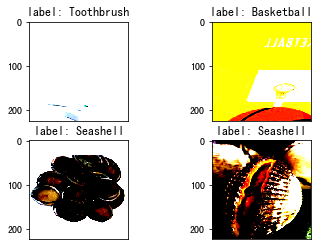

In [6]:
ds = create_dataset(config=config, training=False)
data = ds.create_dict_iterator(output_numpy=True).get_next()
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title('label: %s' % inverted[labels[i]])
    plt.xticks([])
plt.show()

## 2. 训练策略

一般情况下，模型训练时采用静态学习率，如0.01。随着训练步数的增加，模型逐渐趋于收敛，对权重参数的更新幅度应该逐渐降低，以减小模型训练后期的抖动。所以，模型训练时可以采用动态下降的学习率，常见的学习率下降策略有：

- polynomial decay/square decay;
- cosine decay;
- exponential decay;
- stage decay.

这里实现cosine decay和square decay下降策略。

In [7]:
def build_lr(total_steps, lr_init=0.0, lr_end=0.0, lr_max=0.1, warmup_steps=0, decay_type='cosine'):
    """
    Applies cosine decay to generate learning rate array.

    Args:
       total_steps(int): all steps in training.
       lr_init(float): init learning rate.
       lr_end(float): end learning rate
       lr_max(float): max learning rate.
       warmup_steps(int): all steps in warmup epochs.

    Returns:
       list, learning rate array.
    """
    lr_init, lr_end, lr_max = float(lr_init), float(lr_end), float(lr_max)
    decay_steps = total_steps - warmup_steps
    lr_all_steps = []
    inc_per_step = (lr_max - lr_init) / warmup_steps if warmup_steps else 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * (i + 1)
        else:
            if decay_type == 'cosine':
                cosine_decay = 0.5 * (1 + math.cos(math.pi * (i - warmup_steps) / decay_steps))
                lr = (lr_max - lr_end) * cosine_decay + lr_end
            elif decay_type == 'square':
                frac = 1.0 - float(i - warmup_steps) / (total_steps - warmup_steps)
                lr = (lr_max - lr_end) * (frac * frac) + lr_end
            else:
                lr = lr_max
        lr_all_steps.append(lr)

    return lr_all_steps

观察不同学习率下降策略的曲线：

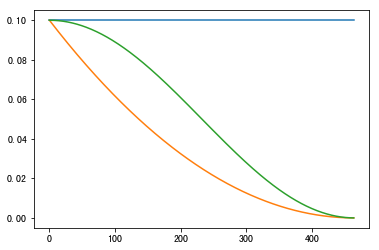

In [8]:
steps = 5*93
plt.plot(range(steps), build_lr(steps, lr_max=0.1, decay_type='constant'))
plt.plot(range(steps), build_lr(steps, lr_max=0.1, decay_type='square'))
plt.plot(range(steps), build_lr(steps, lr_max=0.1, decay_type='cosine'))
plt.show()

## 3. 模型训练

在模型训练过程中，可以添加检查点（Checkpoint）用于保存模型的参数，以便进行推理及中断后再训练使用。使用场景如下：

- 训练后推理场景
    - 模型训练完毕后保存模型的参数，用于推理或预测操作。
    - 训练过程中，通过实时验证精度，把精度最高的模型参数保存下来，用于预测操作。
- 再训练场景
    - 进行长时间训练任务时，保存训练过程中的Checkpoint文件，防止任务异常退出后从初始状态开始训练。
    - Fine-tuning（微调）场景，即训练一个模型并保存参数，基于该模型，面向第二个类似任务进行模型训练。

这里加载ImageNet数据上预训练的MobileNetv2进行Fine-tuning，并在训练过程中保存Checkpoint。训练有两种方式：
- 方式一：冻结网络的Backbone，只训练修改的FC层（Head）。其中，Backbone再全量数据集上做一遍推理，得到Feature Map，将Feature Map作为训练Head的数据集，可以极大节省训练时间。
- 方式二：先冻结网络的Backbone，只训练网络Head；再对Backbone+Head做整网做微调。

### 3.1 提取特征集

将冻结层在全量训练集上做一遍推理，然后保存FeatureMap，作为修改层的数据集。

In [9]:
def extract_features(net, dataset_path, config):
    if not os.path.exists(config.features_path):
        os.makedirs(config.features_path)
    dataset = create_dataset(config=config)
    step_size = dataset.get_dataset_size()
    if step_size == 0:
        raise ValueError("The step_size of dataset is zero. Check if the images count of train dataset is more \
            than batch_size in config.py")

    data_iter = dataset.create_dict_iterator()
    for i, data in enumerate(data_iter):
        features_path = os.path.join(config.features_path, f"feature_{i}.npy")
        label_path = os.path.join(config.features_path, f"label_{i}.npy")
        if not os.path.exists(features_path) or not os.path.exists(label_path):
            image = data["image"]
            label = data["label"]
            features = net(image)
            np.save(features_path, features.asnumpy())
            np.save(label_path, label.asnumpy())
        print(f"Complete the batch {i+1}/{step_size}")
    return

backbone = MobileNetV2Backbone()
load_checkpoint(config.pretrained_ckpt, net=backbone)
extract_features(backbone, config.dataset_path, config)

Complete the batch 1/390
Complete the batch 2/390
Complete the batch 3/390
Complete the batch 4/390
Complete the batch 5/390
Complete the batch 6/390
Complete the batch 7/390
Complete the batch 8/390
Complete the batch 9/390
Complete the batch 10/390
Complete the batch 11/390
Complete the batch 12/390
Complete the batch 13/390
Complete the batch 14/390
Complete the batch 15/390
Complete the batch 16/390
Complete the batch 17/390
Complete the batch 18/390
Complete the batch 19/390
Complete the batch 20/390
Complete the batch 21/390
Complete the batch 22/390
Complete the batch 23/390
Complete the batch 24/390
Complete the batch 25/390
Complete the batch 26/390
Complete the batch 27/390
Complete the batch 28/390
Complete the batch 29/390
Complete the batch 30/390
Complete the batch 31/390
Complete the batch 32/390
Complete the batch 33/390
Complete the batch 34/390
Complete the batch 35/390
Complete the batch 36/390
Complete the batch 37/390
Complete the batch 38/390
Complete the batch 39

### 3.2 训练 Head 层

自定义Head层，CPU/GPU上算子支持情况请参考：https://www.mindspore.cn/doc/note/zh-CN/r1.0/operator_list_ms.html

In [10]:
class GlobalPooling(nn.Cell):
    """
    Global avg pooling definition.

    Args:
        reduction: mean or max, which means AvgPooling or MaxpPooling.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> GlobalAvgPooling()
    """

    def __init__(self, reduction='mean'):
        super(GlobalPooling, self).__init__()
        if reduction == 'max':
            self.mean = ms.ops.ReduceMax(keep_dims=False)
        else:
            self.mean = ms.ops.ReduceMean(keep_dims=False)

    def construct(self, x):
        x = self.mean(x, (2, 3))
        return x


class MobileNetV2Head(nn.Cell):
    """
    MobileNetV2Head architecture.

    Args:
        input_channel (int): Number of channels of input.
        hw (int): Height and width of input, 7 for MobileNetV2Backbone with image(224, 224).
        num_classes (int): Number of classes. Default is 1000.
        reduction: mean or max, which means AvgPooling or MaxpPooling.
        activation: Activation function for output logits.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> MobileNetV2Head(num_classes=1000)
    """

    def __init__(self, input_channel=1280, hw=7, num_classes=1000, reduction='mean', activation="None"):
        super(MobileNetV2Head, self).__init__()
        if reduction:
            self.flatten = GlobalPooling(reduction)
        else:
            self.flatten = nn.Flatten()
            input_channel = input_channel * hw * hw
        self.dense = nn.Dense(input_channel, num_classes, weight_init='ones', has_bias=False)
        if activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "Softmax":
            self.activation = nn.Softmax()
        else:
            self.need_activation = False

    def construct(self, x):
        x = self.flatten(x)
        x = self.dense(x)
        if self.need_activation:
            x = self.activation(x)
        return x

在提取的特征集上训练Head层，即修改层。

In [11]:
def train_head():
    train_dataset = create_dataset(config=config)
    eval_dataset = create_dataset(config=config)
    step_size = train_dataset.get_dataset_size()
    
    backbone = MobileNetV2Backbone()
    # Freeze parameters of backbone. You can comment these two lines.
    for param in backbone.get_parameters():
       param.requires_grad = False
    load_checkpoint(config.pretrained_ckpt, net=backbone)

    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes, reduction=config.reduction)
    network = mobilenet_v2(backbone, head)

    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    lrs = build_lr(config.epochs * step_size, lr_max=config.lr_max, warmup_steps=0, decay_type=config.decay_type)
    opt = nn.Momentum(head.trainable_params(), lrs, config.momentum, config.weight_decay)
    net = nn.WithLossCell(head, loss)
    train_step = nn.TrainOneStepCell(net, opt)
    train_step.set_train()
    
    # train
    history = list()
    features_path = config.features_path
    idx_list = list(range(step_size))
    for epoch in range(config.epochs):
        random.shuffle(idx_list)
        epoch_start = time.time()
        losses = []
        for j in idx_list:
            feature = Tensor(np.load(os.path.join(features_path, f"feature_{j}.npy")))
            label = Tensor(np.load(os.path.join(features_path, f"label_{j}.npy")))
            losses.append(train_step(feature, label).asnumpy())
        epoch_seconds = (time.time() - epoch_start)
        epoch_loss = np.mean(np.array(losses))
        
        history.append(epoch_loss)
        print("epoch: {}, time cost: {}, avg loss: {}".format(epoch + 1, epoch_seconds, epoch_loss))
        if (epoch + 1) % config.save_ckpt_epochs == 0:
            save_checkpoint(network, os.path.join(config.save_ckpt_path, f"mobilenetv2-{epoch+1}.ckpt"))
    
    # evaluate
    print('validating the model...')
    eval_model = Model(network, loss, metrics={'acc', 'loss'})
    acc = eval_model.eval(eval_dataset, dataset_sink_mode=False)
    print(acc)
    
    return history

由于MobileNetV2网络较大，验证（validate）模型时执行的是整网，整网在CPU平台上执行较慢，如遇卡住或者验证过程中Notebook中断，请重启Kernel后重新执行。

epoch: 1, time cost: 29.285929441452026, avg loss: 2.694850444793701
epoch: 2, time cost: 11.365081548690796, avg loss: 2.6908152103424072
epoch: 3, time cost: 11.220574855804443, avg loss: 2.6930594444274902


[WARNING] ME(64:139902367680320,MainProcess):2024-05-13-21:57:59.970.05 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 4, time cost: 11.680486917495728, avg loss: 2.699873447418213
validating the model...
{'loss': 2.6314220452919983, 'acc': 0.31025641025641026}


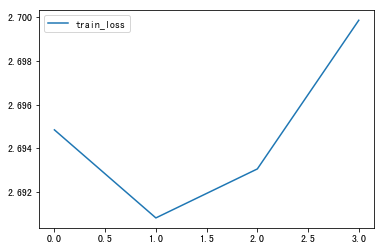

Chosen checkpoint is mobilenetv2-4.ckpt


In [12]:
if os.path.exists(config.save_ckpt_path):
    shutil.rmtree(config.save_ckpt_path)
os.makedirs(config.save_ckpt_path)

history = train_head()

plt.plot(history, label='train_loss')
plt.legend()
plt.show()

CKPT = f'mobilenetv2-{config.epochs}.ckpt'
print("Chosen checkpoint is", CKPT)

## 4. 模型推理

加载模型Checkpoint进行推理。

> 使用load_checkpoint接口加载数据时，需要把数据传入给原始网络，而不能传递给带有优化器和损失函数的训练网络。

In [13]:
def image_process(image):
    """Precess one image per time.
    
    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def infer_one(network, image_path):
    image = Image.open(image_path).resize((config.image_height, config.image_width))
    logits = network(image_process(image))
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    print(image_path, inverted[pred])
    return pred

def infer(images):
    backbone = MobileNetV2Backbone()
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes, reduction=config.reduction)
    network = mobilenet_v2(backbone, head)
    print('加载模型路径:',os.path.join(config.save_ckpt_path, CKPT))
    load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), net=network)
    for img in images:
        infer_one(network, img)

In [14]:
test_images = list()
folder = os.path.join(config.dataset_path, 'val/00_01') # Hats
for img in os.listdir(folder):
    test_images.append(os.path.join(folder, img))

infer(test_images)

加载模型路径: ./results/ckpt_mobilenetv2/mobilenetv2-4.ckpt
./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_01/00010.jpg Paint bucket
./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_01/00037.jpg Paint bucket
./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_01/00040.jpg Paint bucket
./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_01/00055.jpg Paint bucket
./datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_01/00064.jpg Paint bucket


## 5. 导出 MindIR 模型文件

当有了 CheckPoint 文件后，如果想继续基于 MindSpore Lite 在手机端做推理，需要通过网络和 Checkpoint 生成对应的 MindIR 格式模型文件。当前支持基于静态图，且不包含控制流语义的推理网络导出。导出该格式文件的代码如下：

In [ ]:
backbone = MobileNetV2Backbone()
# 导出带有Softmax层的模型
head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes,
                       reduction=config.reduction, activation='Softmax')
network = mobilenet_v2(backbone, head)
load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), net=network)

input = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(network, Tensor(input), file_name=config.export_path, file_format='MINDIR')

## 6. 在手机上部署模型（附加题）

MindSpore提供了面想手机及IoT设备的高性能、轻量化端侧推理框架。访问MindSpore Lite官网了解更多：https://www.mindspore.cn/lite/

通过本实验可以了解如何在端侧利用MindSpore Lite C++ API（Android JNI）以及MindSpore Lite图像分类模型完成端侧推理，实现对设备摄像头捕获的内容进行分类，并在App图像预览界面中显示出最可能的分类结果。

实验教程和代码示例请下载：[mobilenetv2_android.zip](https://share-course.obs.cn-north-4.myhuaweicloud.com/materials/mobilenetv2_android.zip)。另外，也可以参考MindSpore官网教程[实现一个图像分类应用](https://www.mindspore.cn/tutorial/lite/zh-CN/r1.0/quick_start/quick_start.html)。

> **注意：** 当前示例代码仅支持Android手机，无Android手机的同学可尝试通过AndroidStudio自带的模拟器体验。

## 7. 作业评分

**注意：**

通过对以上步骤流程的了解，相信大家对深度学习有了深刻的认识，但是模型比较简单，准确率也不高，大家可以试着写自己的深度学习模型，并将其调到最佳状态。          
1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改函数接口），也可以自己实现深度学习模型，写好代码后可以在 Py 文件中使用 GPU 进行模型训练。
2. 在训练模型等过程中如果需要**保存数据、模型**等请写到 **results** 文件夹，如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请务必将模型保存在 **results** 文件夹下。
3. 训练出自己最好的模型后，先按照下列 cell 操作方式实现 NoteBook 加载模型测试；请测试通过在进行【系统测试】。
4. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
5. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
6. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
7. `predict()`函数的输入和输出请不要改动。

===========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [18]:
## 生成 main.py 时请勾选此 cell
# 本示范以 NoteBook 训练模型通过平台测试为例：

# 1. 导入相关包
import os
import cv2
import numpy as np
import mindspore as ms
from mindspore import nn
from mindspore import Tensor
from easydict import EasyDict
from mindspore import context
from mindspore.train.serialization import load_checkpoint
from src_mindspore.mobilenetv2 import MobileNetV2Backbone, mobilenet_v2  # 模型定义脚本

os.environ['GLOG_v'] = '2'  # Log Level = Error
has_gpu = (os.system('command -v nvidia-smi') == 0)
print('Excuting with', 'GPU' if has_gpu else 'CPU', '.')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU' if has_gpu else 'CPU')

# 2.系统测试部分标签与该处一致，请不要改动
# 垃圾分类数据集标签，以及用于标签映射的字典。
index = {'00_00': 0, '00_01': 1, '00_02': 2, '00_03': 3, '00_04': 4, '00_05': 5, '00_06': 6, '00_07': 7,
         '00_08': 8, '00_09': 9, '01_00': 10, '01_01': 11, '01_02': 12, '01_03': 13, '01_04': 14,
         '01_05': 15, '01_06': 16, '01_07': 17, '02_00': 18, '02_01': 19, '02_02': 20, '02_03': 21,
         '03_00': 22, '03_01': 23, '03_02': 24, '03_03': 25}
inverted = {0: 'Plastic Bottle', 1: 'Hats', 2: 'Newspaper', 3: 'Cans', 4: 'Glassware', 5: 'Glass Bottle', 6: 'Cardboard', 7: 'Basketball',
            8: 'Paper', 9: 'Metalware', 10: 'Disposable Chopsticks', 11: 'Lighter', 12: 'Broom', 13: 'Old Mirror', 14: 'Toothbrush',
            15: 'Dirty Cloth', 16: 'Seashell', 17: 'Ceramic Bowl', 18: 'Paint bucket', 19: 'Battery', 20: 'Fluorescent lamp', 21: 'Tablet capsules',
            22: 'Orange Peel', 23: 'Vegetable Leaf', 24: 'Eggshell', 25: 'Banana Peel'}

Excuting with CPU .


In [20]:
## 生成 main.py 时请勾选此 cell

# 3. NoteBook 模型调整参数部分，你可以根据自己模型需求修改、增加、删除、完善部分超参数
# 训练超参
config = EasyDict({
    "num_classes": 26,
    "reduction": 'mean',
    "image_height": 224,
    "image_width": 224,
    "eval_batch_size": 10
})

# 4. 自定义模型Head部分
class GlobalPooling(nn.Cell):
    def __init__(self, reduction='mean'):
        super(GlobalPooling, self).__init__()
        if reduction == 'max':
            self.mean = ms.ops.ReduceMax(keep_dims=False)
        else:
            self.mean = ms.ops.ReduceMean(keep_dims=False)

    def construct(self, x):
        x = self.mean(x, (2, 3))
        return x


class MobileNetV2Head(nn.Cell):
    def __init__(self, input_channel=1280, hw=7, num_classes=1000, reduction='mean', activation="None"):
        super(MobileNetV2Head, self).__init__()
        if reduction:
            self.flatten = GlobalPooling(reduction)
        else:
            self.flatten = nn.Flatten()
            input_channel = input_channel * hw * hw
        self.dense = nn.Dense(input_channel, num_classes, weight_init='ones', has_bias=False)
        if activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "Softmax":
            self.activation = nn.Softmax()
        else:
            self.need_activation = False

    def construct(self, x):
        x = self.flatten(x)
        x = self.dense(x)
        if self.need_activation:
            x = self.activation(x)
        return x


# -------------------------- 5.请加载您最满意的模型 ---------------------------
# 首先加载网络模型
backbone = MobileNetV2Backbone()
head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes, reduction=config.reduction)
network = mobilenet_v2(backbone, head)

# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的模型，则 model_path = './results/ckpt_mobilenetv2/mobilenetv2-4.ckpt'

model_path = './results/ckpt_mobilenetv2/mobilenetv2-5.ckpt'
load_checkpoint(model_path, net=network)

# ---------------------------------------------------------------------------

def image_process(image):
    """Precess one image per time.
    
    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def predict(image):
    """
    加载模型和模型预测
    主要步骤:
        1.图片处理,此处尽量与训练模型数据处理一致
        2.用加载的模型预测图片的类别
    :param image: OpenCV 读取的图片对象，数据类型是 np.array，shape (H, W, C)
    :return: string, 模型识别图片的类别, 
            包含 'Plastic Bottle','Hats','Newspaper','Cans'等共 26 个类别
    """
    # -------------------------- 实现图像处理部分的代码 ---------------------------
    # 该处是与 NoteBook 训练数据预处理一致；
    # 如使用其它方式进行数据处理，请修改完善该处，否则影响成绩
#     image = cv2.resize(image,(config.image_height, config.image_width))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(config.image_height, config.image_width))
    image = image_process(image)
    
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    logits = network(image)
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    
    return inverted[pred]

In [21]:
# 输入图片路径和名称
image_path = './datasets/5fbdf571c06d3433df85ac65-momodel/garbage_26x100/val/00_00/00037.jpg'

# 使用 opencv 读取图片
image = cv2.imread(image_path)

# 打印返回结果
print(predict(image))

Plastic Bottle
